# EE219 Project 2

Team members:  
Yichen Wu 504294181  
Siyuan Chen 405024391

## Required Packages:
nltk v3.2.5  
numpy v1.14.0  
scikit-learn v0.19.1  
scipy 1.0.0  
matplotlib v2.1.2  

In [2]:
import string
from sklearn.feature_extraction.text import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import NMF, TruncatedSVD, PCA
import nltk

from sklearn.metrics import *
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import *

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

'''
try:
    nltk.download("stopwords")  # if the host does not have the package
except (RuntimeError):
    pass
'''

# globals
MIN_DF = 3


class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self


tfidf_transformer = TfidfTransformer(smooth_idf=False)


def doTFIDF(data, mindf):
    vectorizer = CountVectorizer(min_df=mindf, stop_words=ENGLISH_STOP_WORDS)
    m = vectorizer.fit_transform(data)
    m_train_tfidf = tfidf_transformer.fit_transform(m)
    return m_train_tfidf


def cluster_kmean(data, n):
    km = KMeans(n_clusters=n, max_iter=100, n_init=2, verbose=False).fit(data)
    pred = km.predict(data)
    return pred


def report_stats(label, predict, classes, display=True, msg=None):
    n = len(classes)
    cmatrix = contingency_matrix(label, predict)
    if display:
        plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.BuGn)
        plt.title("Contingency Table")
        tick_marks = np.arange(n)
        className = []
        for i in range(n):
            className.append(str(i))
        plt.xticks(tick_marks, className)
        plt.yticks(tick_marks, classes)
        fmt = 'd'
        thresh = cmatrix.max() / 2.
        for i, j in itertools.product(range(n), range(n)):
            plt.text(j, i, format(cmatrix[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cmatrix[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('Ground Truth Label')
        plt.xlabel('Cluster Label')
        plt.show()

    homogeneity = homogeneity_score(label, predict)
    completeness = completeness_score(label, predict)
    v_measure = v_measure_score(label, predict)
    adjusted_Rand_Index = adjusted_rand_score(label, predict)
    adjusted_Mutual_Info_Score = adjusted_mutual_info_score(label, predict)

    if isinstance(msg, str):
        print(msg)
    print("Homogeneity: %0.3f" % homogeneity)
    print("Completeness: %0.3f" % completeness)
    print("V-measure: %0.3f" % v_measure)
    print("Adjusted Rand-Index: %.3f" % adjusted_Rand_Index)
    print("Adjusted Mutual Info Score: %0.3f" % adjusted_Mutual_Info_Score)

    return [cmatrix, [homogeneity, completeness, v_measure, adjusted_Rand_Index, adjusted_Mutual_Info_Score]]


This part is to load data and import the library that we need for this project.

In [5]:
import numpy as np
import logging
import os
import pickle
from logging.config import fileConfig
from sklearn.datasets import fetch_20newsgroups

# create logger
fileConfig('logging_config.ini')
logger = logging.getLogger()
logger.setLevel("WARNING")
# logger.setLevel("INFO")

categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

cat_comp = categories[:4]   # Computer Technologies
cat_rec = categories[4:]    # Recreational Activities
CAT = ["Computer Technologies", "Recreational Activities"]

logging.info("loading data")
# all_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)
train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# create labels
# 0 for computer technology, 1 for recreational activities
# all_label = [(x//4) for x in all_data.target]
train_label = [(x//4) for x in train_data.target]
test_label = [(x//4) for x in test_data.target]

logging.info("loading finished")



#### a)

In [6]:
from timeit import default_timer as timer

GET_DATA_FROM_FILES = True
DETAILS = False

logging.info("Problem 1")
start = timer()

X_train_tfidf = None
if GET_DATA_FROM_FILES and os.path.isfile("./train_tfidf.pkl"):
    logging.info("Loading tfidf vector.")
    X_train_tfidf = pickle.load(open("./train_tfidf.pkl", "rb"))
else:
    X_train_tfidf = doTFIDF(train_data.data, MIN_DF)
    pickle.dump(X_train_tfidf, open("./train_tfidf.pkl", "wb"))

print("With min_df = %d , (training documents, terms extracted): " % MIN_DF, X_train_tfidf.shape)

duration = timer() - start
logging.debug("Computation Time in secs: %d" % duration)
logging.info("finished Problem 1")


With min_df = 3 , (training documents, terms extracted):  (4732, 20297)


#### b)

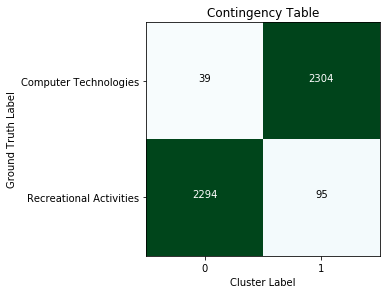

Homogeneity: 0.818
Completeness: 0.818
V-measure: 0.818
Adjusted Rand-Index: 0.890
Adjusted Mutual Info Score: 0.818


In [7]:

logging.info("Problem 2")
start = timer()

km_pred = None
if GET_DATA_FROM_FILES and os.path.isfile("./kmean.pkl"):
    logging.info("Loading predicted kmean.")
    km_pred = pickle.load(open("./kmean.pkl", "rb"))
else:
    km_pred = cluster_kmean(X_train_tfidf, 2)
    pickle.dump(km_pred, open("./kmean.pkl", "wb"))

report_stats(train_label, km_pred, CAT)

duration = timer() - start
logging.debug("Computation Time in secs: %d" % duration)
logging.info("finished Problem 2")

#### c) - 1

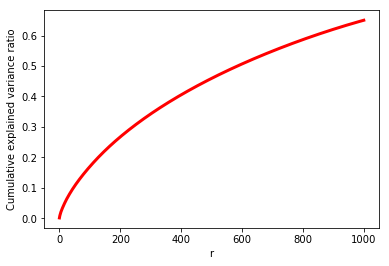

In [8]:
logging.info("Problem 3")
start = timer()

R_MAX = 1000
ratio = None
if GET_DATA_FROM_FILES and os.path.isfile("./ratio.pkl"):
    logging.info("Loading ratio.")
    ratio = pickle.load(open("./ratio.pkl", "rb"))
else:
    svd = TruncatedSVD(n_components=R_MAX, n_iter=7)
    svd.fit_transform(X_train_tfidf)
    ratio = svd.explained_variance_ratio_.cumsum()
    pickle.dump(ratio, open("./ratio.pkl", "wb"), True)

plt.plot(range(R_MAX), ratio, 'r', lw=3, label='Cumulative explained variance ratio')
plt.ylabel('Cumulative explained variance ratio')
plt.xlabel('r')
plt.show()


#### c) - 2

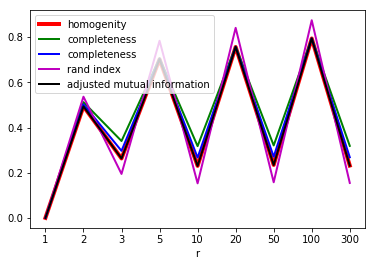

************************************************************
The best R value for TruncatedSVD is 100
The contingency matrix is: 
[[2259   84]
 [  69 2320]]
Homogeneity: 0.794
Completeness: 0.794
V-measure: 0.794
Adjusted Rand-Index: 0.875
Adjusted Mutual Info Score: 0.794
************************************************************


In [30]:
r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

# LSI
y_lsi = None
cmatrix_lsi = None
if GET_DATA_FROM_FILES and not DETAILS \
        and os.path.isfile("./y_lsi.pkl") \
        and os.path.isfile("./cmatrix_lsi.pkl"):
    logging.info("Loading y and cmatrix for LSI.")
    y_lsi = pickle.load(open("./y_lsi.pkl", "rb"))
    cmatrix_lsi = pickle.load(open("./cmatrix_lsi.pkl", "rb"))
else:
    y_lsi = []
    cmatrix_lsi = []
    for i in r:
        svd = TruncatedSVD(n_components=i, random_state=None)
        # normalizer = Normalizer(copy=False)
        # pipeline = make_pipeline(svd, normalizer)
        # X_train_lsi = pipeline.fit_transform(X_train_tfidf)
        X_train_lsi = svd.fit_transform(X_train_tfidf)
        kmean = cluster_kmean(X_train_lsi, 2)
        msg = 'With r = %d' % i + " Using LSI"
        result = report_stats(train_label, kmean, CAT, display=False, msg=msg)
        print("-  "*10)
        print("The contingency matrix is: ")
        cmatrix_lsi.append(result[0])
        print(result[0])
        y_lsi.append(result[1])
        print("-"*30)

    pickle.dump(y_lsi, open("./y_lsi.pkl", "wb"), True)
    pickle.dump(cmatrix_lsi, open("./cmatrix_lsi.pkl", "wb"), True)

y_transpose = np.array(y_lsi).T.tolist()

r_len = len(r)
l1, = plt.plot(range(r_len), y_transpose[0], 'r', lw=4, label='homogenity')
l2, = plt.plot(range(r_len), y_transpose[1], 'g', lw=2, label='completeness')
l3, = plt.plot(range(r_len), y_transpose[2], 'b', lw=2, label='completeness')
l4, = plt.plot(range(r_len), y_transpose[3], 'm', lw=2, label='rand index')
l5, = plt.plot(range(r_len), y_transpose[4], 'k', lw=2, label='adjusted mutual information')
tick_marks = np.arange(r_len)
labels = [str(a) for a in r]
plt.xticks(tick_marks, labels)
plt.legend(handles=[l1, l2, l3, l4, l5])
plt.xlabel('r')
plt.show()

best_r = [np.argmax(y_transpose[i]) for i in range(5)]
print("*"*60)
bi_lsi = np.bincount(best_r).argmax() # best_r_index
print("The best R value for TruncatedSVD is %d" % r[bi_lsi])
print("The contingency matrix is: ")
print(cmatrix_lsi[bi_lsi])
print("Homogeneity: %0.3f" % y_transpose[0][bi_lsi])
print("Completeness: %0.3f" % y_transpose[1][bi_lsi])
print("V-measure: %0.3f" % y_transpose[2][bi_lsi])
print("Adjusted Rand-Index: %.3f" % y_transpose[3][bi_lsi])
print("Adjusted Mutual Info Score: %0.3f" % y_transpose[4][bi_lsi])
print("*"*60)


**Note:** the result(best R value) is random and unrepeatable with different random_state! (Need luck to get to global minimum for each R.)

#### c) - 3

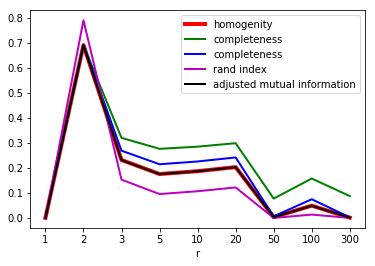

************************************************************
The best R value for NMF is 2
The contingency matrix is: 
[[ 119 2224]
 [2245  144]]
Homogeneity: 0.691
Completeness: 0.691
V-measure: 0.691
Adjusted Rand-Index: 0.790
Adjusted Mutual Info Score: 0.691
************************************************************


In [29]:
# NMF
if GET_DATA_FROM_FILES and not DETAILS \
        and os.path.isfile("./y_nmf.pkl") \
        and os.path.isfile("./cmatrix_nmf.pkl"):
    logging.info("Loading y and cmatrix for NMF.")
    y_nmf = pickle.load(open("./y_nmf.pkl", "rb"))
    cmatrix_nmf = pickle.load(open("./cmatrix_nmf.pkl", "rb"))
else:
    y_nmf = []
    cmatrix_nmf = []
    for i in r:
        nmf = NMF(n_components=i)
        # normalizer = Normalizer(copy=False)
        # pipeline = make_pipeline(svd, normalizer)
        # X_train_lsi = pipeline.fit_transform(X_train_tfidf)
        X_train_nmf = nmf.fit_transform(X_train_tfidf)
        kmean = cluster_kmean(X_train_nmf, 2)
        msg = 'With r = %d' % i + " Using NMF"
        result = report_stats(train_label, kmean, CAT, display=False, msg=msg)
        print("-  "*10)
        print("The contingency matrix is: ")
        cmatrix_nmf.append(result[0])
        print(result[0])
        y_nmf.append(result[1])
        print("-"*30)
    pickle.dump(y_nmf, open("./y_nmf.pkl", "wb"), True)
    pickle.dump(cmatrix_nmf, open("./cmatrix_nmf.pkl", "wb"), True)

y_transpose = np.array(y_nmf).T.tolist()

r_len = len(r)
l1, = plt.plot(range(r_len), y_transpose[0], 'r', lw=4, label='homogenity')
l2, = plt.plot(range(r_len), y_transpose[1], 'g', lw=2, label='completeness')
l3, = plt.plot(range(r_len), y_transpose[2], 'b', lw=2, label='completeness')
l4, = plt.plot(range(r_len), y_transpose[3], 'm', lw=2, label='rand index')
l5, = plt.plot(range(r_len), y_transpose[4], 'k', lw=2, label='adjusted mutual information')
tick_marks = np.arange(r_len)
labels = [str(a) for a in r]
plt.xticks(tick_marks, labels)
plt.legend(handles=[l1, l2, l3, l4, l5])
plt.xlabel('r')
plt.show()

best_r = [np.argmax(y_transpose[i]) for i in range(5)]
print("*"*60)
bi_nmf = np.bincount(best_r).argmax() # best_r_index
print("The best R value for NMF is %d" % r[bi_nmf])
print("The contingency matrix is: ")
print(cmatrix_nmf[bi_nmf])
print("Homogeneity: %0.3f" % y_transpose[0][bi_nmf])
print("Completeness: %0.3f" % y_transpose[1][bi_nmf])
print("V-measure: %0.3f" % y_transpose[2][bi_nmf])
print("Adjusted Rand-Index: %.3f" % y_transpose[3][bi_nmf])
print("Adjusted Mutual Info Score: %0.3f" % y_transpose[4][bi_nmf])
print("*"*60)

duration = timer() - start
logging.debug("Computation Time in secs: %d" % duration)
logging.info("finished Problem 3")

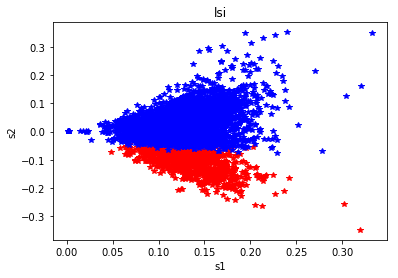

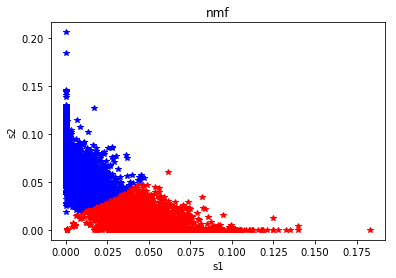

In [33]:
logging.info("Problem 4")
start = timer()

# plot best LSI result

def plot_cluster_2D(r, reduct_method):
    if r < 2:
        logging.warning("Cannot plot. Dimension smaller than 2.")
        return
    
    if reduct_method is 'lsi':
        reduct = TruncatedSVD(n_components=r, random_state=None)
    elif reduct_method is 'nmf':
        reduct = NMF(n_components=r)
    else:
        logging.warning("Cannot plot. Unknown dimensionality reduction method.")
        return
        
    X_train_svd = reduct.fit_transform(X_train_tfidf)
    kmeans = cluster_kmean(X_train_svd, 2)
    
    x1 = X_train_svd[kmeans == 0][:, 0]
    y1 = X_train_svd[kmeans == 0][:, 1]
    x2 = X_train_svd[kmeans == 1][:, 0]
    y2 = X_train_svd[kmeans == 1][:, 1]
    
    plt.plot(x1, y1, 'r*')
    plt.plot(x2, y2, 'b*')
    plt.title(reduct_method)
    plt.xlabel('s1')
    plt.ylabel('s2')
    plt.show()
    
    
plot_cluster_2D(r[bi_lsi], reduct_method='lsi')
plot_cluster_2D(r[bi_nmf], reduct_method='nmf')
